## Data Understanding

In any Data Mining project, understanding your data is crucial. This phase consists of a deep dive into the data, ensuring it's ready for analysis and relevant variables are identified. It's the base upon which we build for data preprocessing and modeling.

This notebook describes the analysis of each table in the given dataset. The goal is to understand the data and identify any issues that need to be addressed before modeling.

In [56]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import pearsonr
from utils.files import *
from utils.metrics import *
import os

DATA_PATH = 'data'
DATA_TEAMS = 'teams.csv'
DATA_COACHES = 'coaches.csv'
DATA_AWARDS = 'awards_players.csv'
DATA_PLAYERS = 'players.csv'
DATA_PLAYERS_TEAMS = 'players_teams.csv'
DATA_SERIES_POST = 'series_post.csv'
DATA_TEAMS_POST = 'teams_post.csv'

In [57]:
# Read the CSV files into data frames
awards_df = pd.read_csv(f'{DATA_PATH}/{DATA_AWARDS}')
coaches_df = pd.read_csv(f'{DATA_PATH}/{DATA_COACHES}')
players_df = pd.read_csv(f'{DATA_PATH}/{DATA_PLAYERS}')
players_teams_df = pd.read_csv(f'{DATA_PATH}/{DATA_PLAYERS_TEAMS}')
teams_df = pd.read_csv(f'{DATA_PATH}/{DATA_TEAMS}')
teams_post_df = pd.read_csv(f'{DATA_PATH}/{DATA_TEAMS_POST}')
series_post_df = pd.read_csv(f'{DATA_PATH}/{DATA_SERIES_POST}')

## Awards

This file defines the awards given to each player or coach throughout the years.
Most of the columns are used for identification purposes, excluding the `award` column, which holds the name of the award given.

In [58]:
print(awards_df.info())
print(awards_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   playerID  95 non-null     object
 1   award     95 non-null     object
 2   year      95 non-null     int64 
 3   lgID      95 non-null     object
dtypes: int64(1), object(3)
memory usage: 3.1+ KB
None
playerID    0
award       0
year        0
lgID        0
dtype: int64


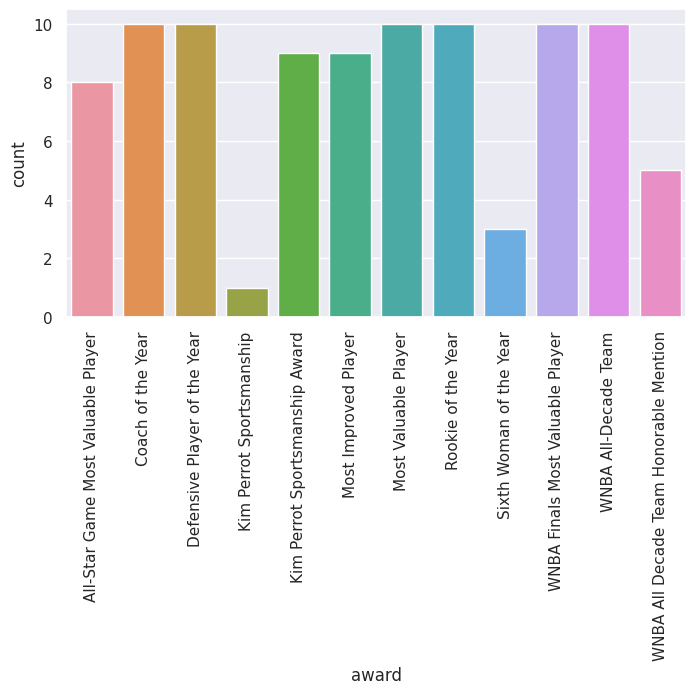

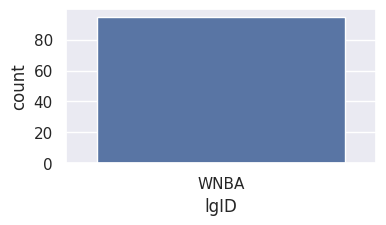

In [59]:
# Plot count plots for award
plt.figure(figsize=(8, 4))
sb.countplot(x='award', data=awards_df)
plt.xticks(rotation=90)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='lgID', data=awards_df)
plt.show()

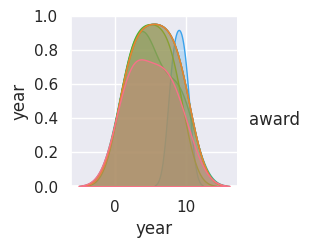

In [60]:
%matplotlib inline
sb.pairplot(awards_df, hue ='award')

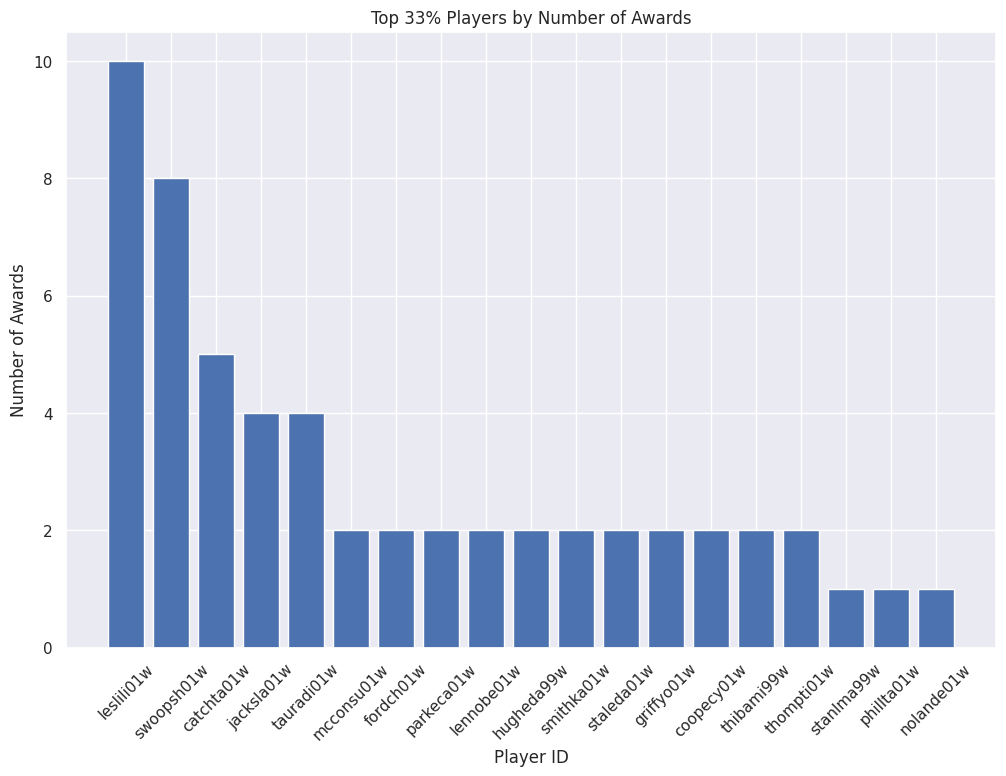

In [61]:
# Group by playerID and count the number of awards
award_counts = awards_df.groupby("playerID")["award"].count().reset_index()

# Sort players by the number of awards in descending order
award_counts = award_counts.sort_values(by="award", ascending=False)

# Calculate the number of players in the top 20%
top_33_percent = int(0.33 * len(award_counts))

# Select the top 20% of players
top_players = award_counts.head(top_33_percent)

# Create a bar plot for the top 20% of players
plt.figure(figsize=(12, 8))
plt.bar(top_players["playerID"], top_players["award"])
plt.xlabel("Player ID")
plt.ylabel("Number of Awards")
plt.title("Top 33% Players by Number of Awards")
plt.xticks(rotation=45)
plt.show()

Some important points surge from the analysis above:
 - `lgID` always has the value "WNBA" (useless)
 - The table does not have null/missing values
 - `leslili01w` is the player with most awards (10).

Furthermore, we will try to understand if the number of awards are somewhat related to the success of a team.


No team found for player coopecy01w in year 7
No team found for player boltoru01w in year 7
No team found for player weathte01w in year 7

Point-biserial correlation coefficient: 0.16988707117905602
P-value: 0.04325261404643388


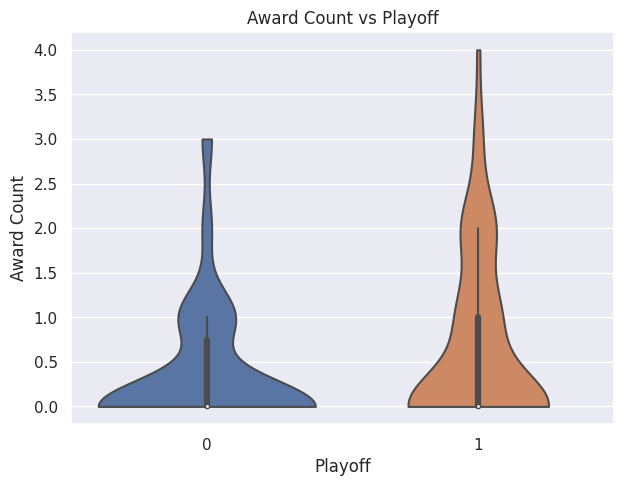

In [62]:
awards_df = awards_df.drop(awards_df[awards_df['award'].str.startswith('Kim Perrot')].index)

# Get the amount of awards in a team
for index, row in awards_df.iterrows():
    # add to awards_df
    tmId = players_teams_df.loc[(players_teams_df['playerID'] == row['playerID']) & (players_teams_df['year'] == row['year'])]['tmID']
    try:
        awards_df.loc[index, 'teamID'] = tmId.iloc[0] 
    except IndexError:
        try:
            tmId = coaches_df.loc[(coaches_df['coachID'] == row['playerID']) & (coaches_df['year'] == row['year'])]['tmID']
            #print(f'No team found for player {row["playerID"]} in year {row["year"]}')
            awards_df.loc[index, 'teamID'] = tmId.iloc[0]
        except:
            print(f'No team found for player {row["playerID"]} in year {row["year"]}')
            awards_df.loc[index, 'teamID'] = 'None'

teams_df_temp = teams_df.copy()
teams_df_temp['yearPrev'] = teams_df_temp['year'] - 1
for index, row in teams_df_temp.iterrows():
    teams_df_temp.loc[index, 'awardCount'] = len(awards_df.loc[(awards_df['teamID'] == row['tmID']) & (awards_df['year'] == row['yearPrev'])].index)

teams_df_temp['playoff'] = teams_df_temp['playoff'].eq('Y').mul(1)

correlation_coefficient, p_value = pointbiserialr(teams_df_temp['awardCount'], teams_df_temp['playoff'])

# Print the result
print(f"\nPoint-biserial correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

sb.violinplot(x='playoff', y='awardCount', data=teams_df_temp, cut=0)
plt.tight_layout()
plt.xlabel('Playoff')
plt.ylabel('Award Count')
plt.title('Award Count vs Playoff')

plt.show()


From the analysis of the violin plot above, we can conclude that the amount of awards has a positive impact in determining if a team will get to the playoffs.
Most teams without awards did not qualify.
Teams with one award are approximately evenly distributed between going to the playoff or not.
Moreover, **all** teams with more than one award went on to play in the playoffs.

Because we are comparing the binary variable `playoff` with the continuos amount of awards, we calculated the Point Biserial correlation between the two.
This metric yielded a value of 0.44, which confirms the theory that the amount of awards does influence a positive result in the series.

Finally, we also noticed that some of the players mentioned in the awards are missing from the database. This can be specially problematic as the players lost are probabily good and thus very influential for a team.

## Coaches

This table defines, besides basic identification, statistics about a coach's performance during the season, namely games won and lost.

The variable `stint` is supposed to represent the moves of coaches during a season:
 - 0 means the coach was there for the whole season
- 1 means the coach was there for the first part of the season
- 2 means the coach was there for the second part of the season 

In [63]:
print(coaches_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   coachID      162 non-null    object
 1   year         162 non-null    int64 
 2   tmID         162 non-null    object
 3   lgID         162 non-null    object
 4   stint        162 non-null    int64 
 5   won          162 non-null    int64 
 6   lost         162 non-null    int64 
 7   post_wins    162 non-null    int64 
 8   post_losses  162 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 11.5+ KB
None


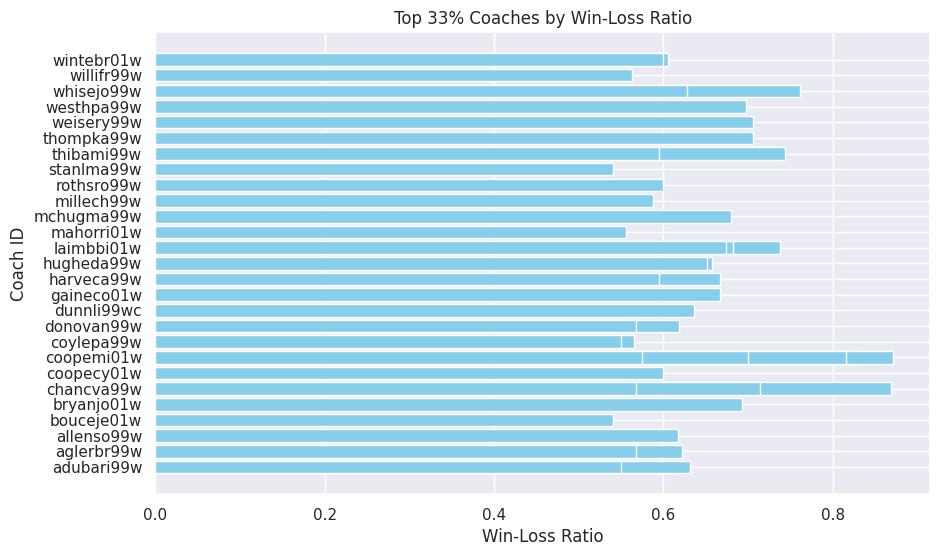

In [64]:
import matplotlib.pyplot as plt

# Calculate win-loss ratio for each coach
coaches_df['wonOverall'] = coaches_df['won'] + coaches_df['post_wins']
coaches_df['lostOverall'] = coaches_df['lost'] + coaches_df['post_losses']
coaches_df['wlRatio'] = coaches_df['wonOverall'] / (coaches_df['wonOverall'] + coaches_df['lostOverall'])

# Calculate the threshold for the top 33%
threshold = coaches_df["wlRatio"].quantile(0.67)  # 67th percentile

# Filter coaches with win-loss ratio above the threshold
top_coaches = coaches_df[coaches_df["wlRatio"] > threshold]

# Create a horizontal bar chart for the top coaches
plt.figure(figsize=(10, 6))
plt.barh(top_coaches["coachID"], top_coaches["wlRatio"], color='skyblue')
plt.xlabel('Win-Loss Ratio')
plt.ylabel('Coach ID')
plt.title('Top 33% Coaches by Win-Loss Ratio')
plt.show()


Some important information can be extracted from the graphics above:
 - `lgID` is always 'WNBA' (useless)
 - The table has no null values 
 - Interesting attribute to create would be `win-loss` ratio. With the creation of this feature, we can discard some remaining information in the table. It can make sense to join regular and post season results, for example.

We will now try to understand if the performance of a coach in the previous season has any impact on the performance of the team in the current season.

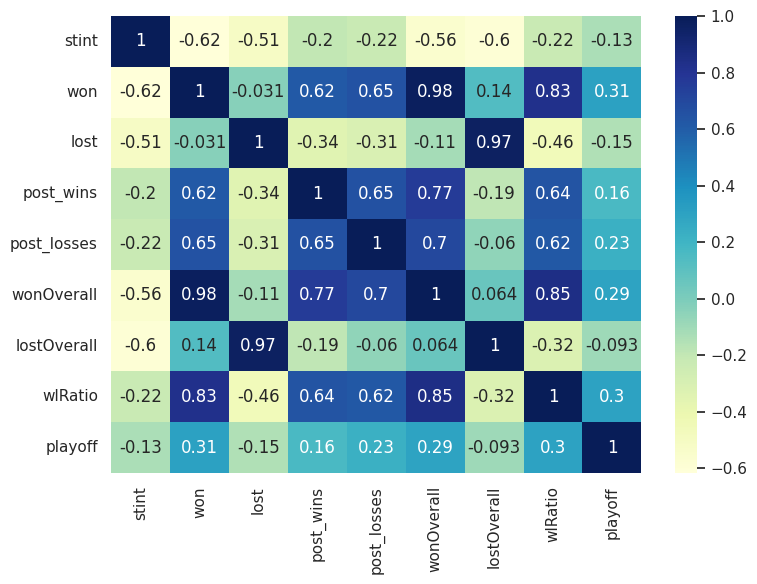

In [65]:
teams_df['yearNext'] = teams_df['year'] + 1
for index, row in coaches_df.iterrows():
    try:
        playoff = teams_df.loc[(teams_df['yearNext'] == row['year']) & (teams_df['tmID'] == row['tmID'])]['playoff'].iloc[0]
        coaches_df.loc[index, 'playoff'] = 1 if (playoff == 'Y') else 0
    except IndexError:
        # last year
        pass

c_df = coaches_df.drop(columns=['coachID', 'tmID', 'lgID', 'year'])
c_df.dropna(inplace=True)
correlation_matrix = c_df.corr()
for col in c_df.columns:
    if c_df[col].dtype == 'int64' and col != 'playoff':
        r, _ = pointbiserialr(c_df['playoff'], c_df[col])
        correlation_matrix.at['playoff', col] = r
        correlation_matrix.at[col, 'playoff'] = r

plt.figure(figsize=(8, 6))
sb.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.tight_layout()
plt.show()


This correlation matrix depicts the Point Biserial correlation between the binary variable `playoff` and the overall results of a coach in the previous season.

The results are not very conclusive, as the correlation is low.
Nevertheless, it's still worth pointing out that the new variable `wlRatio` did positively influence the correlation by a factor of `0.3`, which may be enough to impact training.

## Players_Teams 

This is the largest dataset in the knowledge base, both in dimensionality and sample size.
This increases the need for a thorough data preparation.

The dataset contains statistics about the performance of a player in a given season and team.
The statistics are divided in two categories: regular and post season.
If some of the statistics are unclear, please refer to the <a href="#glossary">Glossary</a> at the end of the notebook.

To understand how influential each statistic can be for the performance a team in a given season, we will calculate the correlation between each statistic and the binary variable `playoff`.
Furthermore, to simplify the analysis, the regular and post season statistics will be joined into a single table.

In [66]:
print(players_teams_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1876 entries, 0 to 1875
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   playerID            1876 non-null   object
 1   year                1876 non-null   int64 
 2   stint               1876 non-null   int64 
 3   tmID                1876 non-null   object
 4   lgID                1876 non-null   object
 5   GP                  1876 non-null   int64 
 6   GS                  1876 non-null   int64 
 7   minutes             1876 non-null   int64 
 8   points              1876 non-null   int64 
 9   oRebounds           1876 non-null   int64 
 10  dRebounds           1876 non-null   int64 
 11  rebounds            1876 non-null   int64 
 12  assists             1876 non-null   int64 
 13  steals              1876 non-null   int64 
 14  blocks              1876 non-null   int64 
 15  turnovers           1876 non-null   int64 
 16  PF                  1876

Discarded 259 rows out of 1876


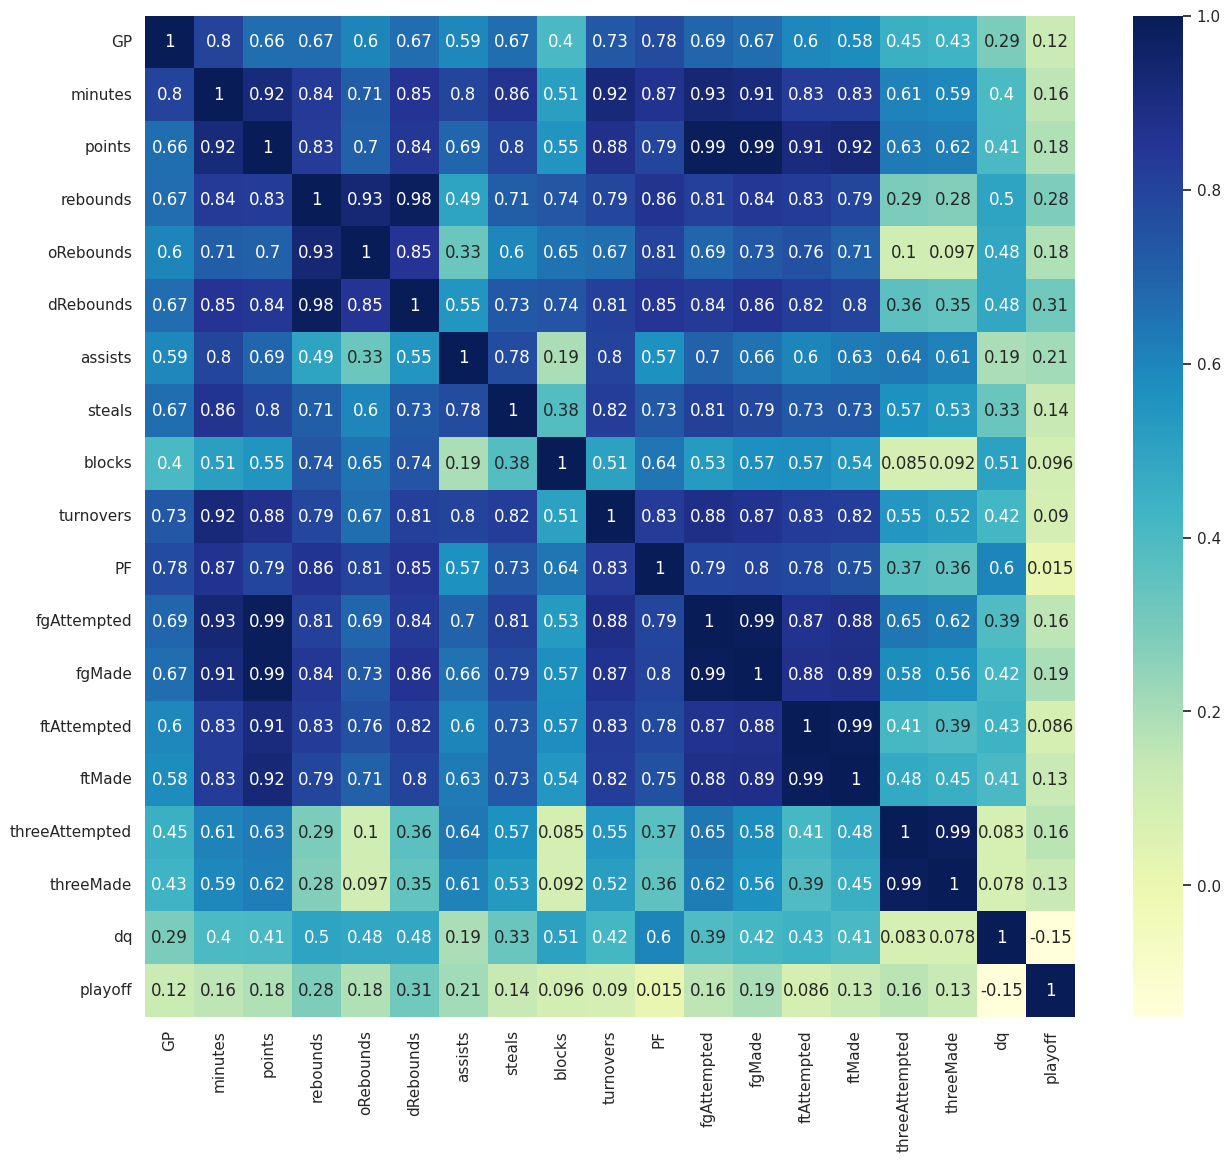

In [67]:
pt_df = preparePlayersTeamsDf(players_teams_df)

teams_df['yearNext'] = teams_df['year'] + 1
countDiscarded = 0
for index, row in pt_df.iterrows():
    try:
        playoff = teams_df.loc[(teams_df['yearNext'] == row['year']) & (teams_df['tmID'] == row['tmID'])]['playoff'].iloc[0]
        pt_df.loc[index, 'playoff'] = 1 if (playoff == 'Y') else 0
    except IndexError:
        countDiscarded += 1
        pass
print(f'Discarded {countDiscarded} rows out of {len(pt_df)}')

pt_df = pt_df.drop(columns=['playerID', 'tmID', 'year'])
pt_df.dropna(inplace=True)
correlation_matrix = pt_df.corr()
for col in pt_df.columns:
    if pt_df[col].dtype == 'int64' and col != 'playoff':
        r, _ = pointbiserialr(pt_df['playoff'], pt_df[col])
        correlation_matrix.at['playoff', col] = r * 10
        correlation_matrix.at[col, 'playoff'] = r * 10

plt.figure(figsize=(15, 13))
sb.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.show()

The matrix above correlates several features from the table in analysis. Additionally, it shows the relation between the table's features and a team getting to the playoffs the next year on the last row.
Note that the correlation values for the latter have been amplified by a factor of 10 in order to help with visualization.

From the relation with the `playoff` variable, it's noticeable that these stats don't severely influence the result. It may be profitable to engineer some together.
From the analysis, we can conclude that the most important features are `rebounds`, `dRebounds` and `assists`.

A lot of features can be considered redundant such as fg, fgAttempted and fgMade.
Moreover, we can also see a high relation between points and point attempts. This is expected, as the more you try to score, the more you will score.
Nevertheless, it opens the door for the deletion of some features, with the objective of avoiding the curse of dimensionality.


<Figure size 1500x1300 with 0 Axes>

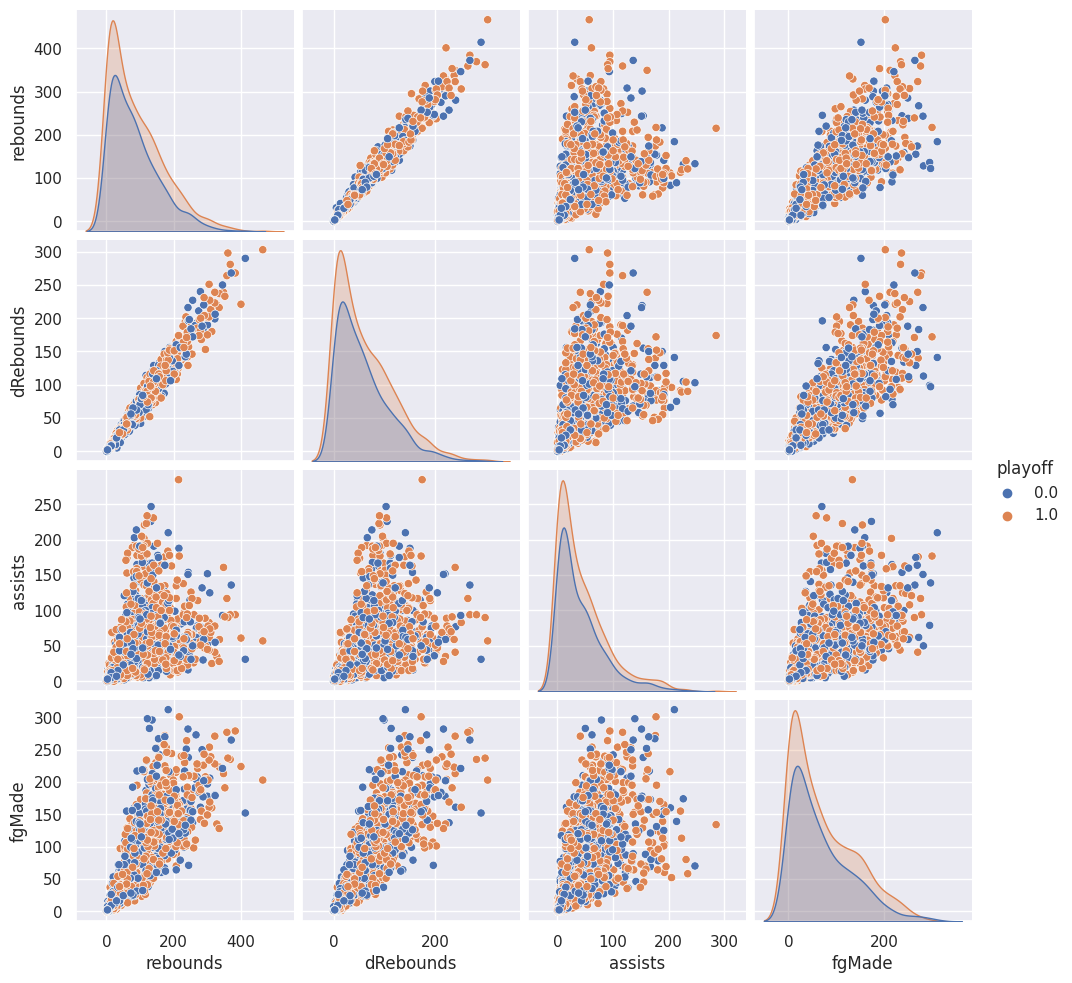

In [68]:
# create scatter plot for all variables
pt_df = pt_df[['playoff', 'rebounds', 'dRebounds', 'assists', 'fgMade']]
plt.figure(figsize=(15, 13))
sb.pairplot(pt_df, hue='playoff')
plt.show()


After plotting multiple scatter plots, we got to the following conclusions:
 - Not a lot of outliers were found. Some points do fall a bit out of the majority, but it's not too significative.
 - The biggest differentiation between teams that go to the playoffs or not lies in the higher values of all the variables. This should be taken into account while computing overall team values.

After finding some variations in team data, we will now try to figure out if a player stays consistent throughout the years.
For that, we will plot the player efficiency rating (EFF).

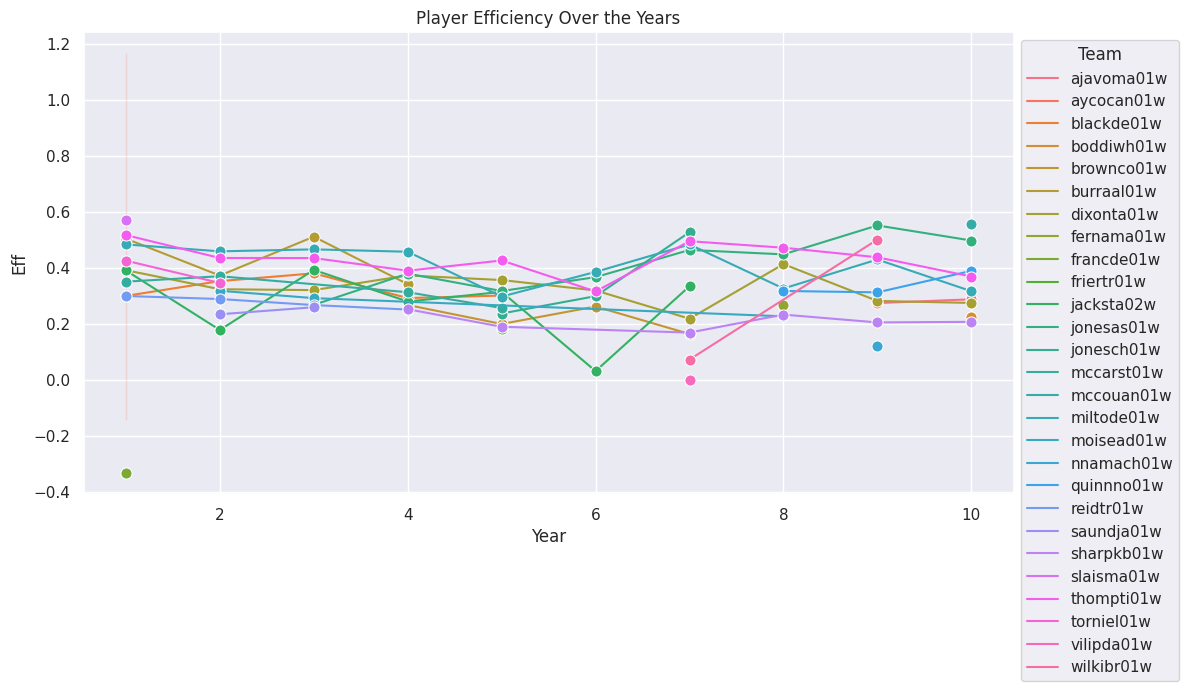

In [69]:
players_teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_PLAYERS_TEAMS))
pt_df = preparePlayersTeamsDf(players_teams_df)

new_pt_df = pd.DataFrame()
for col in ['playerID', 'year', 'tmID']:
    new_pt_df[col] = pt_df[col]

teams_df = pd.read_csv(os.path.join(DATA_PATH, DATA_TEAMS))
teams_df = prepareTeamsDf(teams_df)

getEFF(new_pt_df, pt_df) #defined in metrics.py

players = new_pt_df['playerID'].unique()
players = np.random.choice(players, size=int(0.05 * len(players)), replace=False)
new_pt_df = new_pt_df[new_pt_df['playerID'].isin(players)]

sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=new_pt_df, x='year', y='EFF', hue='playerID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('Eff')
plt.title('Player Efficiency Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



It's noticeable that the players are more consistent than teams through the years.
This means that using player data to predict performance may be more reliable.

## Players

The Players dataset shows basic demographic information about each player, such as height, weight and the college they attended.

Upon first glance, this data does not seem to be very useful for our analysis. However, we will still try to extract some information from it.

In [70]:
print(players_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bioID         893 non-null    object 
 1   pos           815 non-null    object 
 2   firstseason   893 non-null    int64  
 3   lastseason    893 non-null    int64  
 4   height        893 non-null    float64
 5   weight        893 non-null    int64  
 6   college       726 non-null    object 
 7   collegeOther  11 non-null     object 
 8   birthDate     893 non-null    object 
 9   deathDate     893 non-null    object 
dtypes: float64(1), int64(3), object(6)
memory usage: 69.9+ KB
None


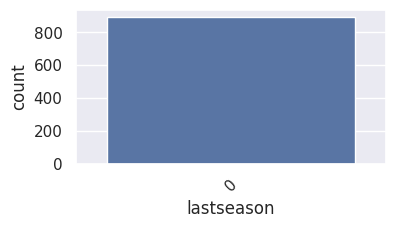

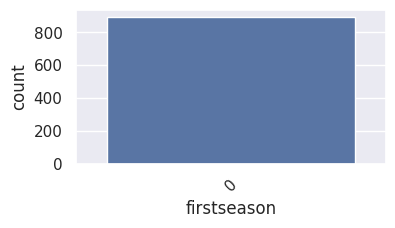

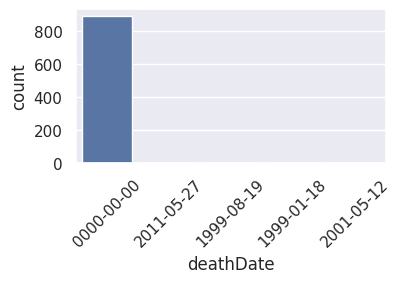

In [71]:
# Plot count plots for players
plt.figure(figsize=(4, 2))
sb.countplot(x='lastseason', data=players_df)
plt.xticks(rotation=45)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='firstseason', data=players_df)
plt.xticks(rotation=45)
plt.show()

# Plot count plots for lgID
plt.figure(figsize=(4, 2))
sb.countplot(x='deathDate', data=players_df)
plt.xticks(rotation=45)
plt.show()



Some conclusions from the graph above include:
 - `firstSeason` and `lastSeason` are always 0
 - `collegeOther` only has 11 entries the rest is null (a lot of null values)
 - `deathDate` is almost always 0000-00-00 and seems irrelevant to the study
 - `pos` and `college` have some missing values

Overall, most attributes are unusable and the others convey information that is not relevant to our study.

Discarded 338 rows out of 893
playoffCount    0.0
dtype: float64


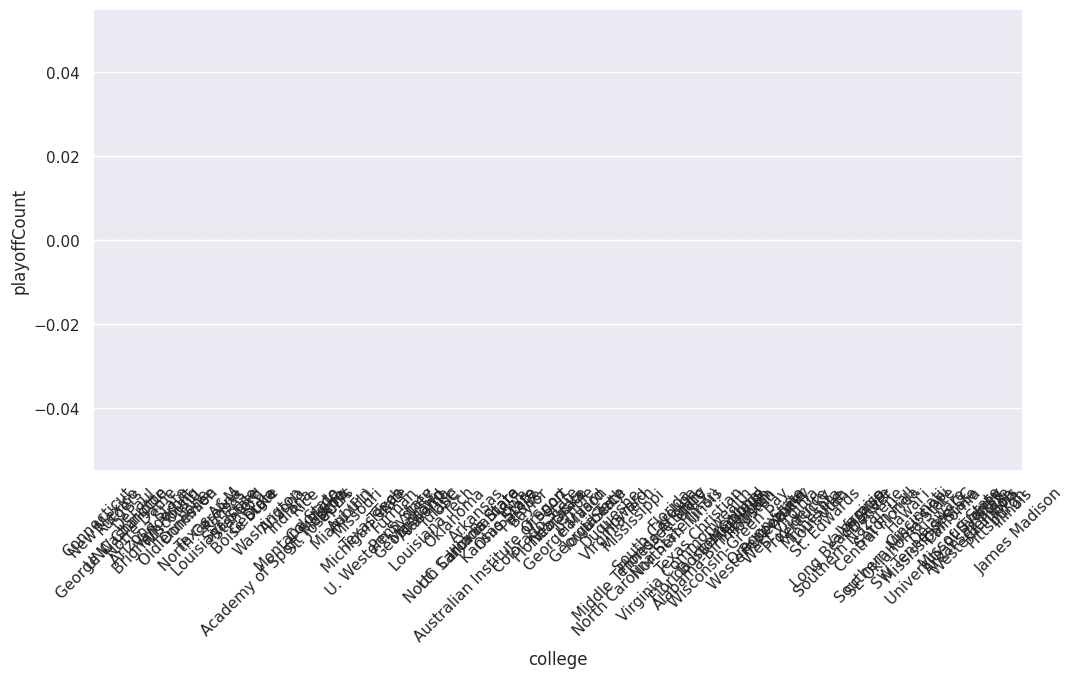

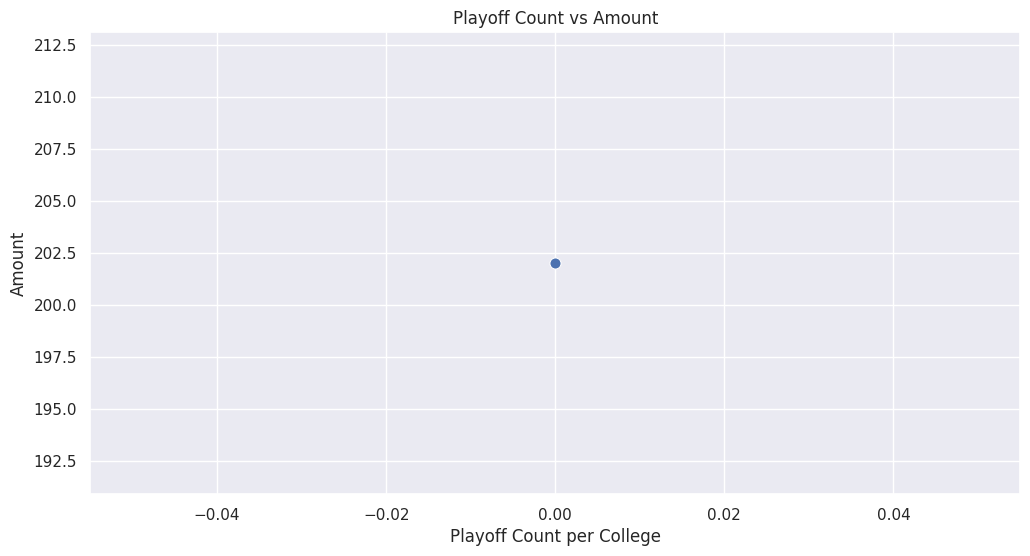

        college  playoffCount
135  Louisville           0.0
         college  playoffCount
0    Connecticut           0.0
138         Utah           0.0
128          NaN           0.0
129   Providence           0.0
130          NaN           0.0
131          NaN           0.0
132          NaN           0.0
133     Kentucky           0.0
134    Minnesota           0.0
135   Louisville           0.0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [92]:
# get the playoff appearences of a player
players_df['playoffCount'] = 0
countDiscarded = 0
college_df = pd.DataFrame(columns=['college', 'playoffCount'])
for index, row in players_df.iterrows():
    tmIds = players_teams_df.loc[(players_teams_df['playerID'] == row['bioID'])][['tmID', 'year']]
    if len(tmIds) == 0:
        countDiscarded += 1
        continue

    for tIndex, tRow in tmIds.iterrows():
        playoff = teams_df.loc[(teams_df['year'] == tRow['year']) & (teams_df['tmID'] == tRow['tmID'])]['playoff'].iloc[0]
        row['playoff'] = 1 if (playoff == 'Y') else 0

    if row['college'] == 'None':
        continue

    if row['college'] not in college_df['college'].values:
        # add row
        college_df.loc[len(college_df)] = [row['college'], 0]
    college_df.loc[college_df['college'] == row['college'], 'playoffCount'] += row['playoff']

print(f'Discarded {countDiscarded} rows out of {len(players_df)}')
print(players_df[['playoffCount']].mean())

plt.figure(figsize=(12, 6))
sb.barplot(x='college', y='playoffCount', data=college_df)
plt.xticks(rotation=45)
plt.show()

count_df = pd.DataFrame(columns=['playoffCount', 'amount'])
for index, row in college_df.iterrows():
    count = row['playoffCount']
    if count not in count_df['playoffCount'].values:
        # add row
        count_df.loc[len(count_df)] = [count, 0]
    count_df.loc[count_df['playoffCount'] == count, 'amount'] += 1

plt.figure(figsize=(12, 6))
sb.lineplot(data=count_df, x='playoffCount', y='amount', marker="o", markersize=8, dashes=False)
plt.xlabel('Playoff Count per College')
plt.ylabel('Amount')
plt.title('Playoff Count vs Amount')
plt.show()

# get count for college louisville
print(college_df.loc[college_df['college'] == 'Louisville'])

#print best 10 colleges
print(college_df.sort_values(by='playoffCount', ascending=False).head(10))

#get average eff per college
getEFF(players_teams_df, players_teams_df) #defined in metrics.py
college_df = pd.DataFrame(columns=['college', 'eff', 'count'])
for index, row in players_teams_df.iterrows():
    college = players_df.loc[players_df['bioID'] == row['playerID']]['college'].iloc[0]
    if college_df.loc[college_df['college'] == college].empty:
        # add row
        college_df.loc[len(college_df)] = [college, 0, 0]
    college_df.loc[college_df['college'] == college, 'eff'] += row['EFF']
    college_df.loc[college_df['college'] == college, 'count'] += 1

college_df['eff'] = college_df['eff'] / college_df['count']

#print best 10 colleges by eff
print(college_df.sort_values(by='eff', ascending=False).head(10))

# Teams Table

This table contains information about a team's performance in a given season.
It includes statistics similar to the ones in the Players_Teams table, but aggregated for the whole team.
There are a lot of statistics divided between offensive and defensive.

Once again, we are dealing with a highly dimensional dataset, so this analysis will be important to determine which features are relevant.

### Null or irrelevant columns

Some whole columns can be discarded as they are either null or irrelevant to the study:

- **franchID, lgID, divID, rank, seeded, name** have either redundant or missing information
- **tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB** are all set to zero
- **homeW, homeL, awayW, awayL, confW, confL** do not convey relevant information
- **min, attend, arena** do not convey relevant information

### Transformations 
- make made/attempted ---> combined_stat = 0.5 * o_fgm/o_fga + 0.5 * o_fgm
    - o_fgm/o_fga, o_ftm/o_fta, o_3pm/o_3pa (teams stats)
    - d_fgm/d_fga, d_ftm/d_fta, d_3pm/d_3pa (opponent stats)
- del o_asts and d_asts?
- make a wlRatio (won/lost)

In [73]:
teams_df = pd.read_csv(f'{DATA_PATH}/{DATA_TEAMS}')
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 61 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        142 non-null    int64  
 1   lgID        142 non-null    object 
 2   tmID        142 non-null    object 
 3   franchID    142 non-null    object 
 4   confID      142 non-null    object 
 5   divID       0 non-null      float64
 6   rank        142 non-null    int64  
 7   playoff     142 non-null    object 
 8   seeded      142 non-null    int64  
 9   firstRound  80 non-null     object 
 10  semis       38 non-null     object 
 11  finals      20 non-null     object 
 12  name        142 non-null    object 
 13  o_fgm       142 non-null    int64  
 14  o_fga       142 non-null    int64  
 15  o_ftm       142 non-null    int64  
 16  o_fta       142 non-null    int64  
 17  o_3pm       142 non-null    int64  
 18  o_3pa       142 non-null    int64  
 19  o_oreb      142 non-null    i

In [74]:
teams_df = prepareTeamsDf(teams_df)

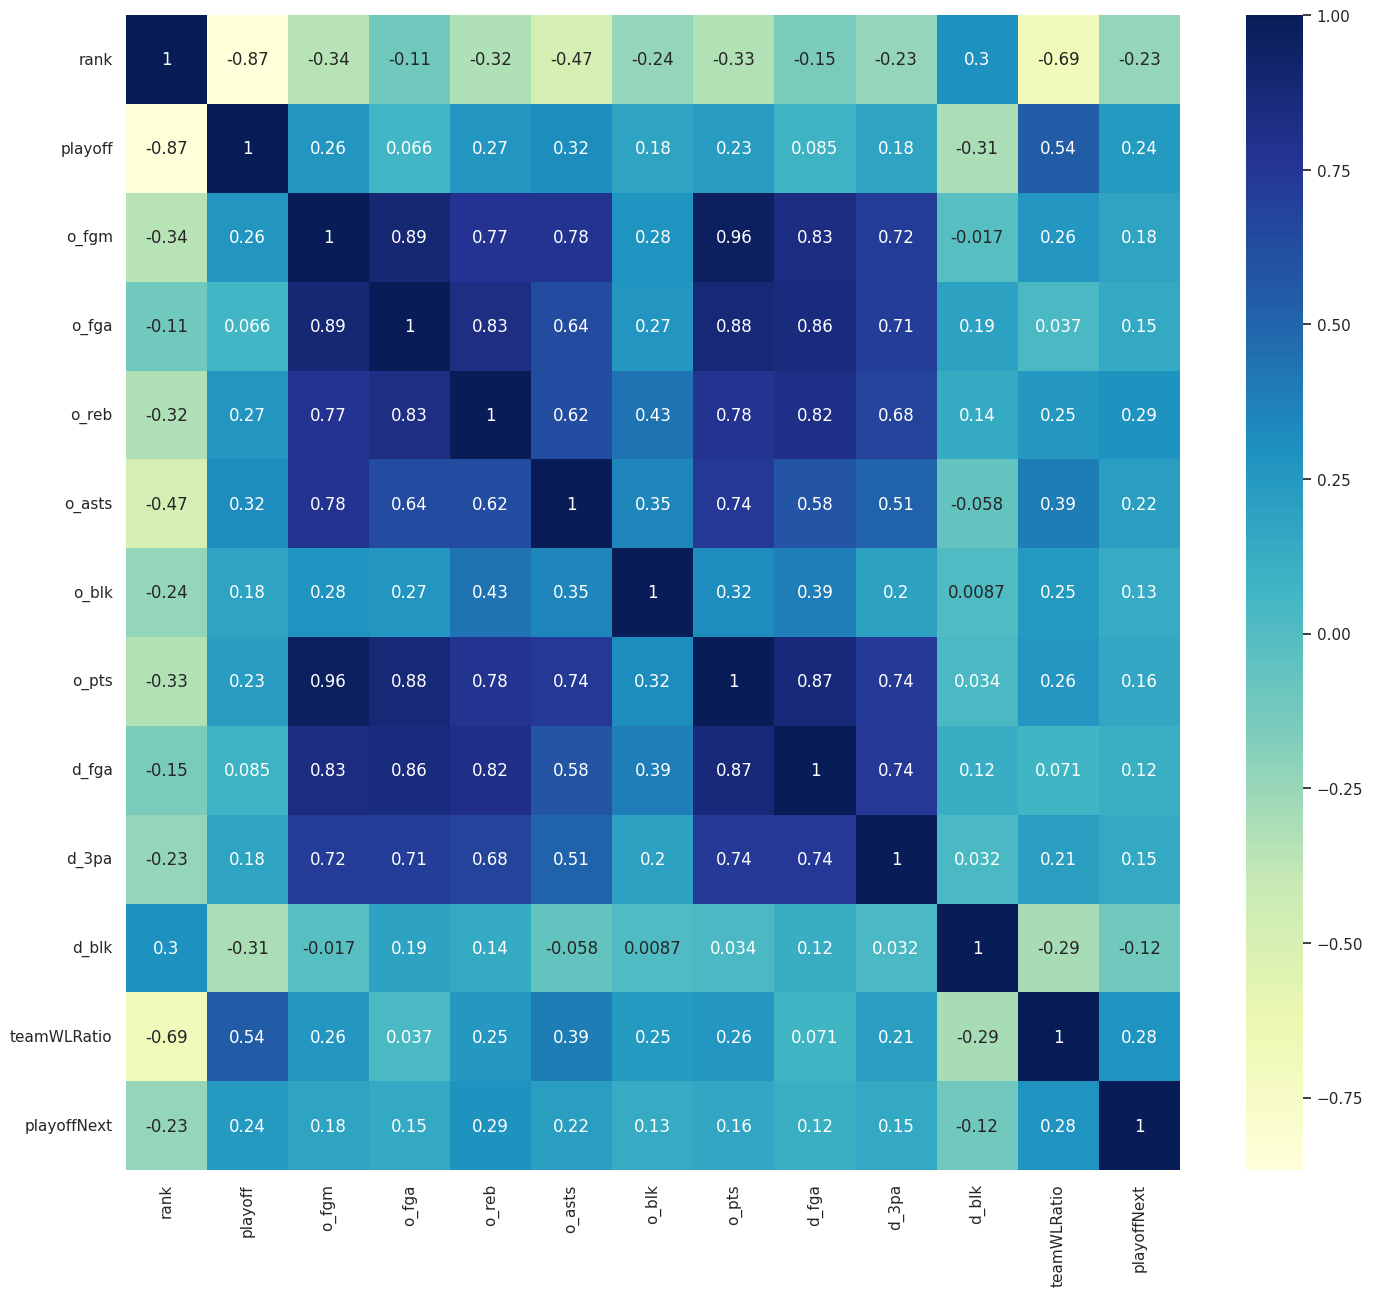

In [75]:
teams_df['playoff'] = teams_df['playoff'].eq('Y').mul(1)

teams_df['yearNext'] = teams_df['year'] + 1
for index, row in teams_df.iterrows():
    try:
        playoff = teams_df.loc[(teams_df['year'] == row['yearNext']) & (teams_df['tmID'] == row['tmID'])]['playoff'].iloc[0]
        teams_df.loc[index, 'playoffNext'] = playoff 
    except IndexError:
        pass

t_df = teams_df.drop(columns=['tmID', 'year', 'confID', 'yearNext'])
t_df.dropna(inplace=True)
correlation_matrix = t_df.corr()
for col in t_df.columns:
    if t_df[col].dtype == 'int64' and col != 'playoffNext':
        r, _ = pointbiserialr(t_df['playoffNext'], t_df[col])
        correlation_matrix.at['playoffNext', col] = r
        correlation_matrix.at[col, 'playoffNext'] = r

# delete rows with less than 0.1 correlation
correlation_matrix = correlation_matrix.loc[correlation_matrix['playoffNext'].abs() >= 0.1, correlation_matrix['playoffNext'].abs() >= 0.1]


plt.figure(figsize=(17, 15))
sb.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.show()


Once again, a correlation matrix was plotted to understand the relation between the features and the target variable `playoff` for the year after.
Columns with a correlation lower than 0.1 to the target variable were discarded as these were of little relevance and would difficult the analysis.

At first glance, its noticeable that most features present include offensive statistics.
This can be an argument in favor of an offensive strategy.

The rebounds greatly influenced the results, as seen in the player data.

Bearing some similarities to the player data, columns related to point scoring (e.g. `o_pts`, `o_fgm`) are highly correlated with each other and thus probably redundant.

An interesting set of well performing features are `rank`, `playoff` and `teamWLRatio`.
This means that teams that performed well in the previous season are likely to perform well in the next season.
However, it does bring the question if this fact is consistent or not, which we will try to find out below.

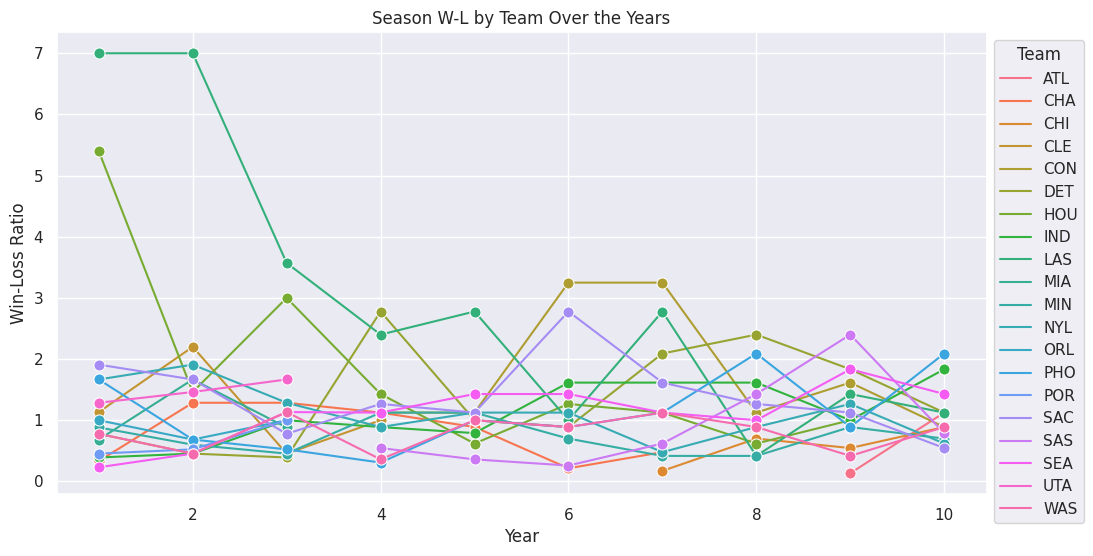

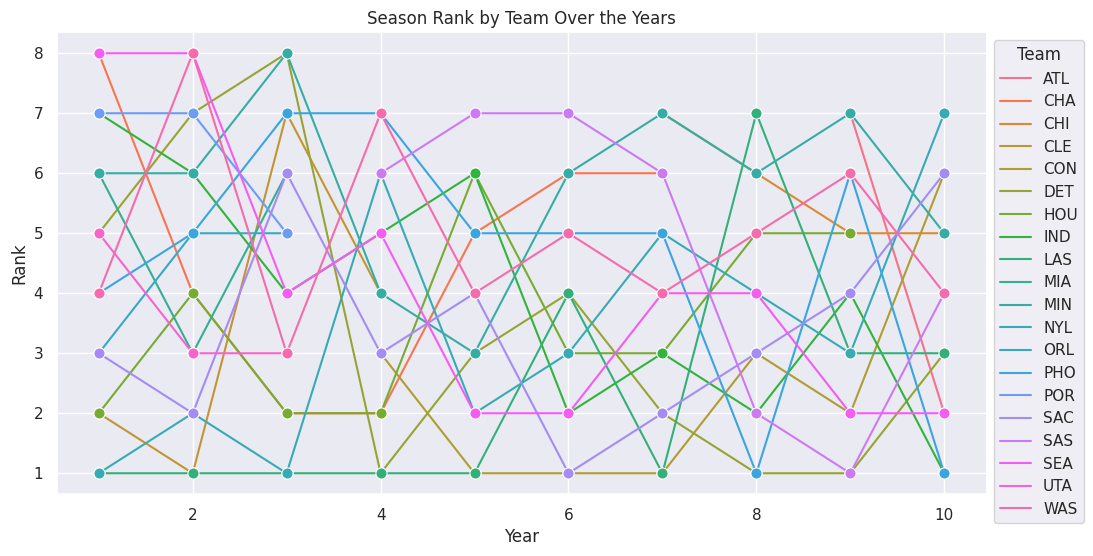

In [76]:

sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=teams_df, x='year', y='teamWLRatio', hue='tmID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('Win-Loss Ratio')
plt.title('Season W-L by Team Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# the same but now rank over the years
sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=teams_df, x='year', y='rank', hue='tmID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('Rank')
plt.title('Season Rank by Team Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


Percentage of players leaving: 0.6428571428571429
Average percentage of players leaving that year: 0.555


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Players leaving and playoff correlation:-0.13290289484548612


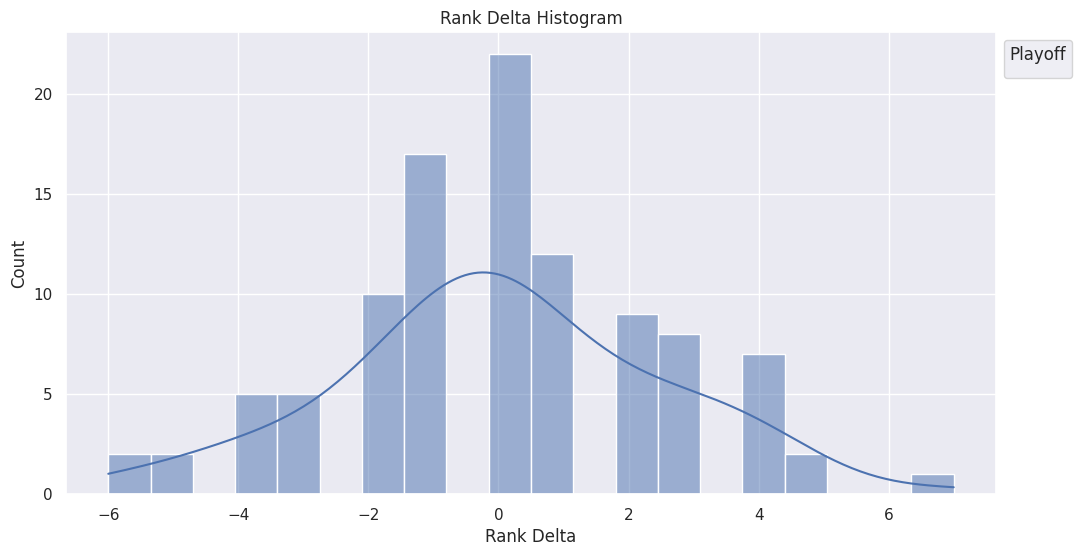

In [77]:
atl9 = players_teams_df.loc[(players_teams_df['tmID'] == 'ATL') & (players_teams_df['year'] == 9)]['playerID']
atl10 = players_teams_df.loc[(players_teams_df['tmID'] == 'ATL') & (players_teams_df['year'] == 10)]['playerID']

#atl9 = players_teams_df.loc[(players_teams_df['tmID'] == 'CLE') & (players_teams_df['year'] == 1)]['playerID']
#atl10 = players_teams_df.loc[(players_teams_df['tmID'] == 'CLE') & (players_teams_df['year'] == 2)]['playerID']

# get the amount of players in both seasons
count = 0
for player in atl9:
    if player in atl10.values:
        count += 1

left_percentage = (len(atl9) - count) / len(atl9)
print(f'Percentage of players leaving: {left_percentage}')

# get the avg of players leaving each season across the whole dataset
count = 0
for index, row in players_teams_df.iterrows():
    if row['year'] == 9:
        if row['playerID'] not in players_teams_df.loc[(players_teams_df['tmID'] == row['tmID']) & (players_teams_df['year'] == 10)]['playerID'].values:
            count += 1
avg_left = count / len(players_teams_df.loc[players_teams_df['year'] == 9])
print(f'Average percentage of players leaving that year: {avg_left}')

teams_df['yearPrev'] = teams_df['year'] - 1
for index, row in teams_df.iterrows():
    try:
        prevYear = teams_df.loc[(teams_df['year'] == row['yearPrev']) & (teams_df['tmID'] == row['tmID'])]
        prevPlayers = players_teams_df.loc[(players_teams_df['tmID'] == row['tmID']) & (players_teams_df['year'] == row['yearPrev'])]['playerID']
        if len(prevPlayers) == 0:
            continue

        count = 0 
        for player in prevPlayers:
            if player not in players_teams_df.loc[(players_teams_df['tmID'] == row['tmID']) & (players_teams_df['year'] == row['year'])]['playerID'].values:
                count += 1

        teams_df.loc[index, 'pLeft'] = count / len(prevPlayers)
    except IndexError:
        pass

#teams_df['pLeft'] = (teams_df['pLeft'] - teams_df['pLeft'].mean()) / teams_df['pLeft'].std()
t_df = teams_df.dropna()
r, _ = pointbiserialr(t_df['playoffNext'], t_df['pLeft'])
print('Players leaving and playoff correlation:' + str(r))

# histogram of rank delta between seasons
for index, row in teams_df.iterrows():
    if row['year'] == 10: continue
    try:
        nextYear = teams_df.loc[(teams_df['year'] == row['yearNext']) & (teams_df['tmID'] == row['tmID'])]
        teams_df.loc[index, 'rankDelta'] = row['rank'] - nextYear['rank'].iloc[0]
    except IndexError:
        pass

t_df = teams_df.dropna()

plt.figure(figsize=(12, 6))
sb.histplot(data=t_df, x='rankDelta', bins=20, kde=True)
plt.xlabel('Rank Delta')
plt.ylabel('Count')
plt.title('Rank Delta Histogram')
plt.legend(title='Playoff', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



We were expecting that a team's result would stay consistent throughout the years, at least for a 2 season time span.
This was not the case however, as there can be seen a lot of variation in the line plot above. 

For instance, the team Atlanta Dreamers, for example, joined the league in the year 9, winning only 4 games.
In the next year, they got first pick of the draft, and selected Angel McCoughtry.
This pick change the shape of the team, as they went on to win 18 games and get to the playoffs. [<a href="#ref2">2</a>]

The draft is a very important event in the league.
It gives the chance for weaker teams, to go first and select better players.
This means that our prediction should not heavily realy on team data, as it can change drastically from one year to the next.

To add to this, it was also observed that, in average, 55% of the team changes every year.

In [78]:
# Teams Playoff Appearances
playoff_teams = teams_df[teams_df['playoff'] == 1]
playoff_counts = playoff_teams['tmID'].value_counts().reset_index()
playoff_counts.columns = ['Team', 'Playoff Appearances']
playoff_counts

,Team,Playoff Appearances
0,LAS,9
1,SAC,8
2,DET,7
3,NYL,7
4,SEA,7
5,CON,6
6,HOU,6
7,IND,6
8,WAS,5
9,SAS,3


Because we are working with data that precedes 2015, 4 teams will be chosen from each conference, instead of choosing the best 8 from the league [<a href="ref1">1</a>].
The table below confirms that the data follows this rules.

In [79]:
# playoff teams per conference per year
playoff_teams = teams_df[teams_df['playoff'] == 1]
playoff_teams = playoff_teams.groupby(['year', 'confID'])['tmID'].count().reset_index()
playoff_teams.columns = ['Year', 'Conference', 'Playoff Teams']
playoff_teams


,Year,Conference,Playoff Teams
0,1,EA,4
1,1,WE,4
2,2,EA,4
3,2,WE,4
4,3,EA,4
5,3,WE,4
6,4,EA,4
7,4,WE,4
8,5,EA,4
9,5,WE,4


# Teams Post Table

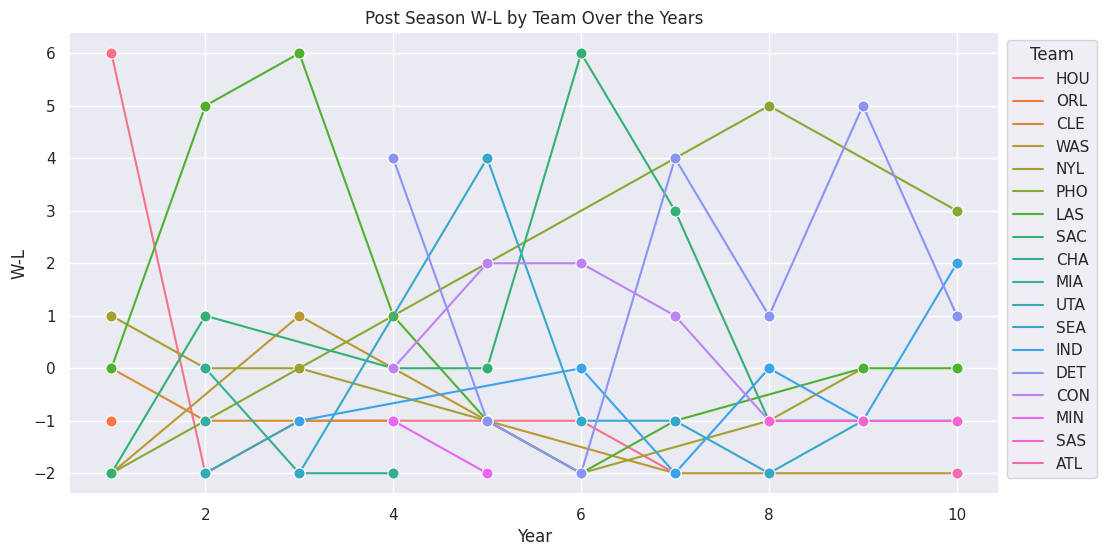

'Bar Graph'

In [80]:
teams_post_df['W-L'] = teams_post_df['W'] - teams_post_df['L'] 

"""Point Graph"""
sb.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sb.lineplot(data=teams_post_df, x='year', y='W-L', hue='tmID', marker="o", markersize=8, dashes=False)
plt.xlabel('Year')
plt.ylabel('W-L')
plt.title('Post Season W-L by Team Over the Years')
plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

"""Bar Graph"""
# sb.set(style="darkgrid")
# plt.figure(figsize=(12, 6))
# sb.barplot(data=teams_post_df, x='year', y='W-L', hue='tmID', palette='Set1')
# plt.xlabel('Year')
# plt.ylabel('W-L')
# plt.title('Post Season W-L by Team Over the Years')
# plt.legend(title='Team', loc='upper left', bbox_to_anchor=(1, 1))
# plt.show()

## Series Post Table

In [81]:
# PlayOffs winning teams:
playoff_wins_df = series_post_df[series_post_df['round'] == 'F']
playoff_wins = playoff_wins_df.groupby('tmIDWinner').size().reset_index(name='PlayOffWins').sort_values(by='PlayOffWins',ascending=False)

playoff_wins

,tmIDWinner,PlayOffWins
0,DET,3
2,LAS,2
3,PHO,2
1,HOU,1
4,SAC,1
5,SEA,1


<h2 id="glossary">Glossary</h2>

| Term | Meaning |
|------|---------|
| o_* | Offensive |
| d_* | Defensive |
| fgm | Field Goals Made |
| fga | Field Goals Attempted |
| ftm | Free Throws Made |
| fta | Free Throws Attempted |
| 3pm | Three-pointers Made |
| 3pa | Three-pointers Attempted |
| reb | Rebounds |
| asts | Assists |
| pf | Player Fouls |
| stl | Steals |
| to | Turn-overs |
| blk | Blocks |
| pts | Points |
| GP | Games Played |
| GS |  |
| dq |  |


## References

<a id="ref1"></a> [1] WNBA approves new playoff format - WNBA. (n.d.). https://www.wnba.com/news/wnba-approves-new-playoff-format

<a id="ref2"></a> [2] The Editors of Encyclopaedia Britannica. (2023, July 26). Atlanta Dream | History, players, & facts. Encyclopedia Britannica. https://www.britannica.com/topic/Atlanta-Dream